# Obtaining AQI Data & Creating a Smoke Metric

This notebook is multifaceted.

First, the notebook goes through the process of obtaining AQI data from measuring devices near Gainesville, FL. This includes obtaining daily measurements and then cleaning the data so it is able to be plotted.

Second, this notebook then leverages a custom metric for measuring smoke impact, denoted as the `smoke metric`, on the city of Gainesville, FL. The details of which are fleshed out in a cell later in the notebook and also in the `README.md` file.

Finally, this notebook compares the `smoke metric` to the AQI to get an idea if the `smoke metric` is of any utility.

## Requirements
1. Cleaned datasert file from `data_clean.ipynb`.
2. Custom python methods from `wildfire` directory placed at the same level as this notebook.
3. Following instructions below for obtaining an API key to get AQI data.
4. Looking through [EPA documentation](https://aqs.epa.gov/aqsweb/documents/data_api.html) to understand data being obtained for this notebook.

## Citations
This entire notebook is an adaptation of a code example developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 16, 2024

In [38]:
import json, time
import requests

import math, os, json, time, re
import geojson
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from collections.abc import Iterable
from geopy.distance import geodesic
from pyproj import Transformer, Geod
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points

In [36]:
# Function for computing the distance of a feature to a city lat/lon coordinate
def distances(city_coords, gdf, miles, return_dist=False):
    """
    Compute distance of all features in a geopandas dataframe to a city lat/lon coorindates.
    
    Args:
        city_coords: 2-tuple of coordinates for a city in (lat,lon) format.
        gdf: A geopandas DataFrame. Should be the data loaded from the cleaned dataset produced via data_clean.ipynb
        miles: Integer, maximum number of miles a ring can be from the city to be saved and returned.
        return_dist: Boolean, returns distance of each ring from city if True.

    Returns:
        distance_filtered_features: list of geopandas rows/fire features that are within the miles range from the city
        dist_list: List with distance of each fire feature was from the city
    """
    dist_list = []
    city_point = Point(city_coords)
    distance_filtered_features = []
    for index, row in gdf.iterrows():
        polygon = row['geometry']
        nearest_point, _ = nearest_points(polygon, city_point)
        dist_miles = geodesic((nearest_point.y, nearest_point.x), city_coords).miles
        if dist_miles <= miles:
            distance_filtered_features.append(row)
            dist_list.append(dist_miles)
    if return_dist:
        return distance_filtered_features, dist_list
    else:
        return distance_filtered_features

### Creating an account and obtaining an API key

Before you can use the API you need to request a key. You will use an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests.

You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key.

#### ASSUMPTIONS
NOTE: A key is necessary for use of the API and is obtained During the process of creating an account. All instances of using the key is hardcoded in this notebook but for privacy reasons the key used during the creation of this notebook has been redacted.
Make sure to place your personal key where necessary to make the code run correctly.

In [3]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "dtropf@uw.edu",     
    "key":        "silvermallard96",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



In [4]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']: 
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

#### Signup below
Uncomment the code below in order to create an account.
Only need to be ran once.

In [ ]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
#print("Requesting SIGNUP ...")
#USERNAME = "dtropf@uw.edu"
#response = request_signup(USERNAME)
#print(json.dumps(response,indent=4))

In [5]:
# Place the APIKEY obtained from signing up below in the variable `APIKEY`
USERNAME = "dtropf@uw.edu"
APIKEY = "silvermallard96"

### Obtaining AQI Data

The below cells leverage the `request_list_info` function to get a daily measurement of AQI.

#### ASSUMPTION
It was assumed that all measuring devices necessary were within the limits of the city of Gainesville, FL.
Look at comments later in the notebook for possible issues with this assumption.

In [18]:
#
#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result


In [19]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [20]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

In [21]:
# Schema used to obtain AQI data and for hitting AQI API
CITY_LOCATIONS = {
    "gainesville":    {"city"   : "Gainesville",
                       "county" : "Alachua",
                       "state"  : "Florida",
                       "fips"   : "12001",
                       "latlon" : [29.68, -82.35]}
}


In [22]:
"""
Obtain the daily AQI info for both gaseous and particulate values for all good years.
Save the data and plot.
"""
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['gainesville']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['gainesville']['fips'][2:]

# request daily summary data for the month of July in 2021
annual_list_gaseous = []
annual_list_particulate = []
for i in range(1961, 2022):
    print(i)
    begin_date = f"{i}0101"
    end_date = f"{i}1231"
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
    extract_gaseous = extract_summary_from_response(gaseous_aqi)
    extract_particulate = extract_summary_from_response(particulate_aqi)
    annual_list_gaseous.append(extract_gaseous)
    annual_list_particulate.append(extract_particulate)

1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


'    \ngaseous_aqi = request_daily_summary(request_template=request_data, begin_date="20210701", end_date="20210731")\nprint("Response for the gaseous pollutants ...")\n#\nif gaseous_aqi["Header"][0][\'status\'] == "Success":\n    print(json.dumps(gaseous_aqi[\'Data\'],indent=4))\nelif gaseous_aqi["Header"][0][\'status\'].startswith("No data "):\n    print("Looks like the response generated no data. You might take a closer look at your request and the response data.")\nelse:\n    print(json.dumps(gaseous_aqi,indent=4))\n\nrequest_data[\'param\'] = AQI_PARAMS_PARTICULATES\n# request daily summary data for the month of July in 2021\nparticulate_aqi = request_daily_summary(request_template=request_data, begin_date="20210701", end_date="20210731")\nprint("Response for the particulate pollutants ...")\n#\nif particulate_aqi["Header"][0][\'status\'] == "Success":\n    print(json.dumps(particulate_aqi[\'Data\'],indent=4))\nelif particulate_aqi["Header"][0][\'status\'].startswith("No data "):\

Data obtained from the API call to get AQI is fairly messy.
The following two cells are to obtain the AQI from the extremely nested data structure.

In [23]:
"""
Get AQI data for the particulate data.
"""
aqi_bad_year_particulate = []
annual_aqi_particulate = []
for i, alp in enumerate(annual_list_particulate):
    aqi_list = []
    for k1 in alp:
        for k2 in alp[k1]['pollutant_type'].keys():
            for k3 in alp[k1]['pollutant_type'][k2]['data'].keys():
                data_list = alp[k1]['pollutant_type'][k2]['data'][k3]
                for data in data_list:
                    aqi = data['aqi']
                    if aqi:
                        aqi_list.append(aqi)
    if aqi_list:
        annual_aqi_particulate.append(sum(aqi_list))
    else:
        aqi_bad_year_particulate.append(i)
print(aqi_bad_year_particulate)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 29, 30, 31, 32, 33, 34, 35]


In [24]:
"""
Get AQI data for gaseous data
"""
aqi_bad_year_gas = []
annual_aqi_gas = []
for i, alp in enumerate(annual_list_gaseous):
    aqi_list = []
    for k1 in alp:
        for k2 in alp[k1]['pollutant_type'].keys():
            for k3 in alp[k1]['pollutant_type'][k2]['data'].keys():
                data_list = alp[k1]['pollutant_type'][k2]['data'][k3]
                for data in data_list:
                    aqi = data['aqi']
                    if aqi:
                        aqi_list.append(aqi)
    if aqi_list:
        annual_aqi_gas.append(sum(aqi_list))
    else:
        aqi_bad_year_gas.append(i)
print(aqi_bad_year_gas)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 29, 30, 31, 32, 33, 34, 35]


In [25]:
"""
Create list of total AQI for each year for plotting.
Set all years lacking data to zero.
"""
bad_years = set(aqi_bad_year_gas).union(set(aqi_bad_year_particulate))
total_aqi = [aqi1+aqi2 for aqi1,aqi2 in zip(annual_aqi_gas, annual_aqi_particulate)]
for i in bad_years:
    total_aqi.insert(i, 0)
print(total_aqi)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11912, 15916, 26224, 62014, 30758, 3520, 16514, 24612, 12768, 1092, 6672, 10604, 18920, 1812, 0, 0, 0, 0, 0, 0, 0, 29206, 119184, 92562, 86420, 102388, 82404, 145038, 164526, 154554, 97846, 91406, 78702, 73654, 84032, 82432, 73502, 70688, 70666, 66610, 73826, 71460, 72912, 75670, 68710, 69708]


### Visualization of AQI

Below is the visualization for annual AQI near Gainesville.

The calculation for AQI is the total sum of all AQI measurements -- gaseous and particulate -- for all daily measurements for all devices in Gainesville, FL (within a 25 mile radius).

Text(0.5, 1.0, 'Annual AQI for Gainesville, FL')

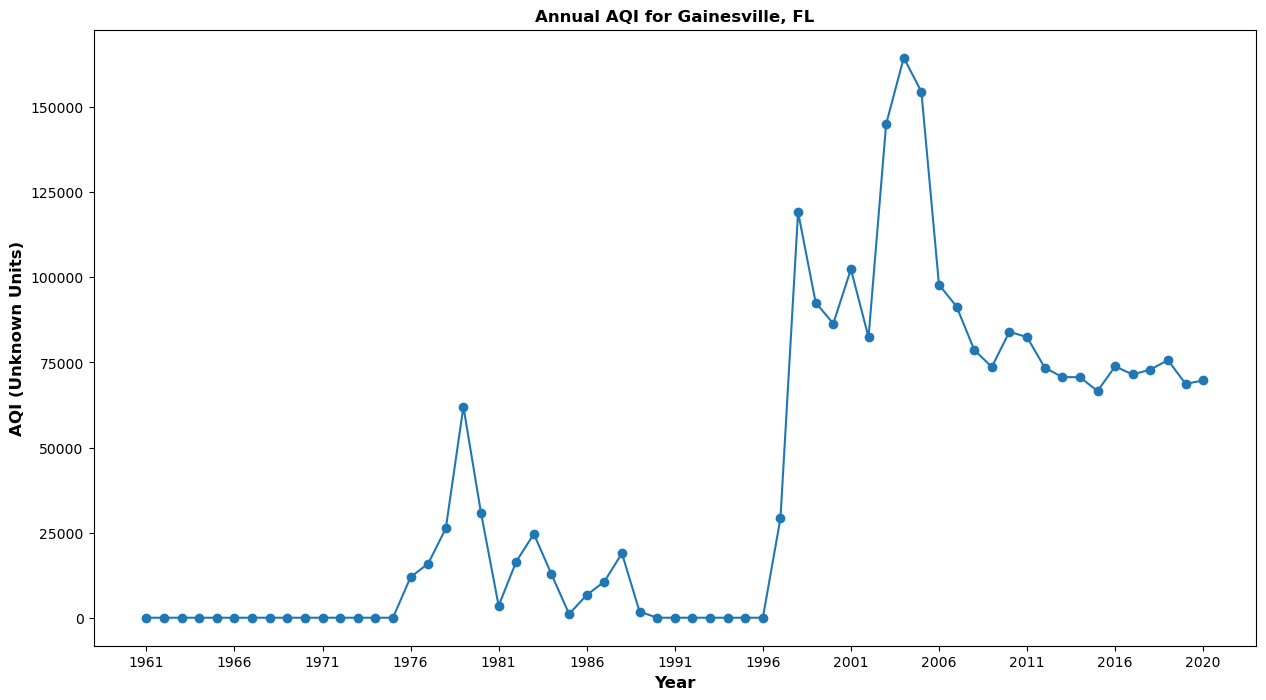

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(total_aqi, marker='o')
ax.set_xticks(ticks=[i for i in range(0, len(total_aqi[:-1]), 5)]+[60], labels=[i for i in range(1961, 2021, 5)]+[2020])
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('AQI (Unknown Units)', fontweight='bold', fontsize=12)
ax.set_title('Annual AQI for Gainesville, FL', fontweight='bold')

### Custom Smoke Metric

Below is the development of the custom smoke metric each year.

The `smoke metric` is calculated as $$\text{smoke metric}=\frac{\text{Total Acres Burned}}{\text{(Average Fire Distance)}^2}$$

This is calculated for each day.

The idea behind the metric:

Assume that a all particles of smoke are concentrated very densely and that they uniformly spread out. Assuming the Earth is flat within the region of the fire to the city, the smoke particles will spread our in the shape of a dome or half sphere. Much like how the universe expands, the dome of smoke particles will expand and maintain this hemisphere shape. As the hemisphere expands, the particles slowly become more distant from one another which decreases density of the smoke particles. Thus, the further away (on average) a fire is, the less of an issue the fire should cause because there are fewer particles in the air per unit volume. This is why the equation is being divided by the square of the distance from the city -- the surface area of a hemisphere is proportional to the square of the radius of the hemisphere (distance from city in this case).


Next, it is also assumed that total acres burned is a good proxy for how much smoke is actually produced from a fire. This is likely inaccurate because not all acres are equal -- some acres may have more fuel to burn than others. Regardless, acres burned is acting as some rough metric for total smoke particles.

Final assumption is to add up the `smoke metric` every day instead of amortize it over the year. This decision is largely made because the dataset is only being looked at for the fireseason of May-October of a given year, so there is really no point in amortizing.

Ultimately, this custom `smoke metric` is acting as a rough estimate for particles per unit area over the city.
It could be divided by the cube instead of square to get a rough estimate of particles per unit volume -- however, because this unitless metric is only useful in the context of this specific data it doesn't really change much.

### Visualization

Below is the calculation of the custom `smoke metric` added up annually and plotted below.

In [39]:
# Load data and transform data coordinates
full_data_path = "./full_data.geojson"
gdf = gpd.read_file(full_data_path)
gdf.crs = 'ESRI:102008'
print(gdf.crs)
gdf.to_crs(epsg=4326, inplace=True)

# Compute distance and obtained acres burned per year
MILES = 650
city_coords = (29.68, -82.35)
annual_list = []
distance_list = []
for year in range(1961,2022):
    year_gdf = gdf[gdf['Fire_Year'] == year]
    rows, dist = distances(city_coords, year_gdf, MILES, return_dist=True)
    annual_list.append(sum([r['GIS_Acres'] for r in rows]))
    distance_list.append(dist)

# Compute custom smoke metric
smoke_metric = [annual_list[i]/np.mean(distance_list[i])**2 for i in range(len(distance_list))]

ESRI:102008


/Users/trop393/miniconda3/envs/uw/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/trop393/miniconda3/envs/uw/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Annual AQI for Gainesville, FL')

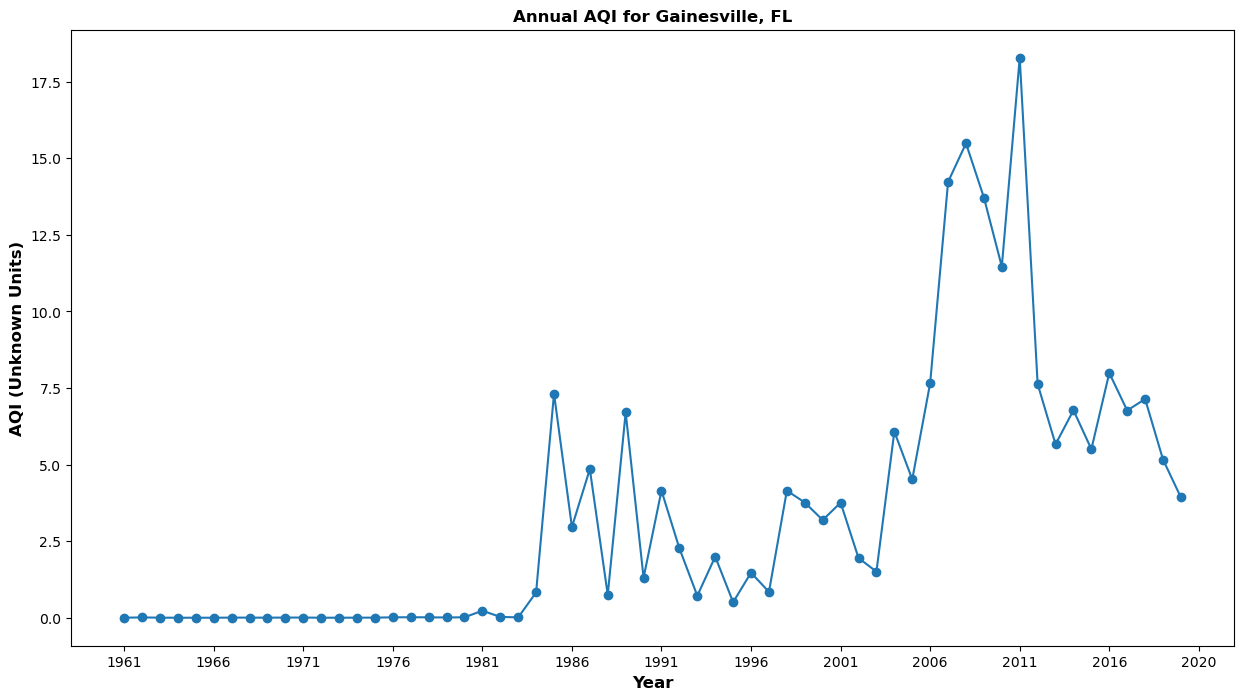

In [40]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(smoke_metric, marker='o')
ax.set_xticks(ticks=[i for i in range(0, len(total_aqi[:-1]), 5)]+[60], labels=[i for i in range(1961, 2021, 5)]+[2020])
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Smoke Metric (Unknown Units)', fontweight='bold', fontsize=12)
ax.set_title('Annual Smoke Metric for Gainesville, FL', fontweight='bold')